In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import plotting_settings
plotting_settings.set_mpl()

from ru_graduates.map_figure import mapFigure
import plotly.io as pio
pio.renderers.default = "notebook"

## Данные

Данные о трудоустройстве выпускников российских организаций среднего специального и высшего образования по направлениям подготовки и уровням образования, собранные из открытых дашбордов Мониторинга трудоустройства выпускников Роструда.

В датасете представлены:

- численность выпускников
- доля занятых
- средняя зарплата
- наименование региона или федерального округа
- коды ОКТМО и ОКАТО

__Данные о трудоустройстве и приведены по состоянию на 31.12.2023, о зарплате — за 12 месяцев 2023 года.__

<font color="gray">Трудоустройство и зарплаты выпускников по направлениям подготовки//Роструд; обработка «Если быть точным», 2024. Условия использования: Creative Commons BY 4.0. URL: https://tochno.st/datasets/graduates_fields</font>

In [2]:
smaller_df = pd.read_csv(
    'data/data_graduates_specialty_125_v20240709_csv/data_graduates_study_area_125_v20240611.csv', sep=';'
    )

fed_dist_bachelor_df = smaller_df.query(
    'object_level == "Федеральный округ" &'
    'education_level == "Бакалавриат, специалитет" &'
    'gender == "Всего"')

fed_dist_master_df = smaller_df.query(
    'object_level == "Федеральный округ" &'
    'education_level == "Магистратура" &'
    'gender == "Всего"')

# print('Пропуски в данных:', '\n')
# for column, n_empty in smaller_df.isna().sum().items():
#     if n_empty > 0:
#         print(
#             f'В "{column}" пропущено {n_empty} из {len(smaller_df)} значений'
#             f' ({n_empty / len(smaller_df):.0%})'
#             )
        
# for column in smaller_df.columns:
#     unique_values = smaller_df[column].unique()
#     if len(unique_values) < 20:
#         print(f'{column}: {unique_values}', '\n')

<div class="alert alert-info"> <b> 🔎</b> На этой карте можно узнать, к каким федеральным округам (ФО) относятся разные области России </div>

In [3]:
#| column: screen-inset-right
russia_map = mapFigure()
import plotly.express as px

regions = pd.read_parquet("data/regions/russia_regions.parquet")
fo_list = list(regions['federal_district'].unique())
colors = px.colors.qualitative.Pastel1

for i, r in regions.iterrows():
    popul_text = f"Население: <b>{r.population:_} </b>".replace('_', ' ')
    text = f'<b>{r.region}</b><br>{r.federal_district} ФО<br>{popul_text}'
    russia_map.update_traces(selector=dict(name=r.region),
        text=text,
        fillcolor=colors[fo_list.index(r.federal_district)])
russia_map.show()

***

## Топ-3 специальностей по среднему размеру зарплат

In [4]:
def plot_top_salaries_by_fd(df):

    # Unique object names to iterate through
    unique_objects = df['object_name'].unique()

    # Setting up the grid (2 rows x 4 columns)
    fig, axes = plt.subplots(2, 4, figsize=(10, 6))
    axes = axes.flatten()  # Flatten the grid to make iteration easier

    # Define a color dictionary for the bars
    color_dict = {
    'Инженерное дело, технологии и технические науки': "#1E88E5",
    'Здравоохранение и медицинские науки': "#13B755",
    'Математические и естественные науки': "#ff0d57",
    'Сельское хозяйство и сельскохозяйственные науки': "#7C52FF",
    'Науки об обществе': "#FFC000",
    'Искусство и культура': "#00AEEF"
    }

    emoji_dict = {
    'Инженерное дело, технологии и технические науки': 'engineer',
    'Здравоохранение и медицинские науки': 'doctor',
    'Математические и естественные науки': 'nerd',
    'Сельское хозяйство и сельскохозяйственные науки': 'rural',
    'Науки об обществе': 'social',
    'Искусство и культура': 'art'
    }

    for i, fed_dist in enumerate(unique_objects):
        # print(i, fed_dist)
        if i >= len(axes):
            break  # In case there are more unique objects than subplots

        fed_bachelor_df = df.query(f'object_name == "{fed_dist}"')
        fed_bachelor_stat_df = (
            fed_bachelor_df.groupby('study_area')['average_salary']
            .median().nlargest(3)
        ).reset_index()  # Resetting index to get a DataFrame

        fed_master_df = fed_dist_master_df.query(f'object_name == "{fed_dist}"')
        fed_master_stat_df = (
            fed_master_df.groupby('study_area')['average_salary']
            .median().nlargest(3)
        ).reset_index()

        ax = axes[i]  # Selecting the corresponding subplot
        
        # Create a color mapping for hue
        fed_bachelor_stat_df['color'] = fed_bachelor_stat_df['study_area'].map(color_dict)
        fed_master_stat_df['color'] = fed_master_stat_df['study_area'].map(color_dict)
        # Plot with hue and disable legend
        sns.barplot(
            x='study_area', y='average_salary', data=fed_bachelor_stat_df, ax=ax,
            hue='color', palette=fed_bachelor_stat_df['color'].tolist(),
            legend=False, alpha=0.7)
        
        # Setting the title for each subplot
        ax.set_title(fed_dist.replace('федеральный округ', 'ФО'), fontsize=15, y=1.05)
        ax.set_ylim(0, 1.7e5)

        ax.set_ylabel('')
        ax.set_xlabel('')

        # ax.set_xlabel('Специальность')

        # Overlaying the image on top of each bar
        for i, bar in enumerate(ax.patches):
            x0 = bar.get_x() + bar.get_width() / 2.0  # Center the image horizontally on the bar
            y0 = bar.get_height()  # Position the image at the top of the bar

            bar_legend = fed_bachelor_stat_df.iloc[i].study_area
            image_file = f'{emoji_dict.get(bar_legend)}.png'
            image = plt.imread(f'data/img/{image_file}')
            image_box = OffsetImage(image, zoom=0.15)  # Adjust zoom as needed
            ab = AnnotationBbox(image_box, (x0, y0), frameon=False, xycoords='data', box_alignment=(0.5, 0.0))
            ax.add_artist(ab)

            # Turn off the upper and right frame edges
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.tick_params(axis='x', bottom=False)

            # Custom formatter function
            def format_yticks(value, _):
                if value >= 1000:
                    return f'{int(value/1000)}K'
                else:
                    return f'{int(value)}'

            # Apply the custom formatter to the y-axis
            ax.yaxis.set_major_formatter(plt.FuncFormatter(format_yticks))

        ax.set_xticklabels([])

        # Adding a common text label for the entire figure
        fig.text(0.5, 0.005, 'Специальность выпускника', ha='center', va='center', fontsize=20, fontweight='bold')
        fig.text(0.001, 0.45, 'Средняя зарплата (рубли)', ha='center', va='center', fontsize=20, fontweight='bold', rotation=90)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

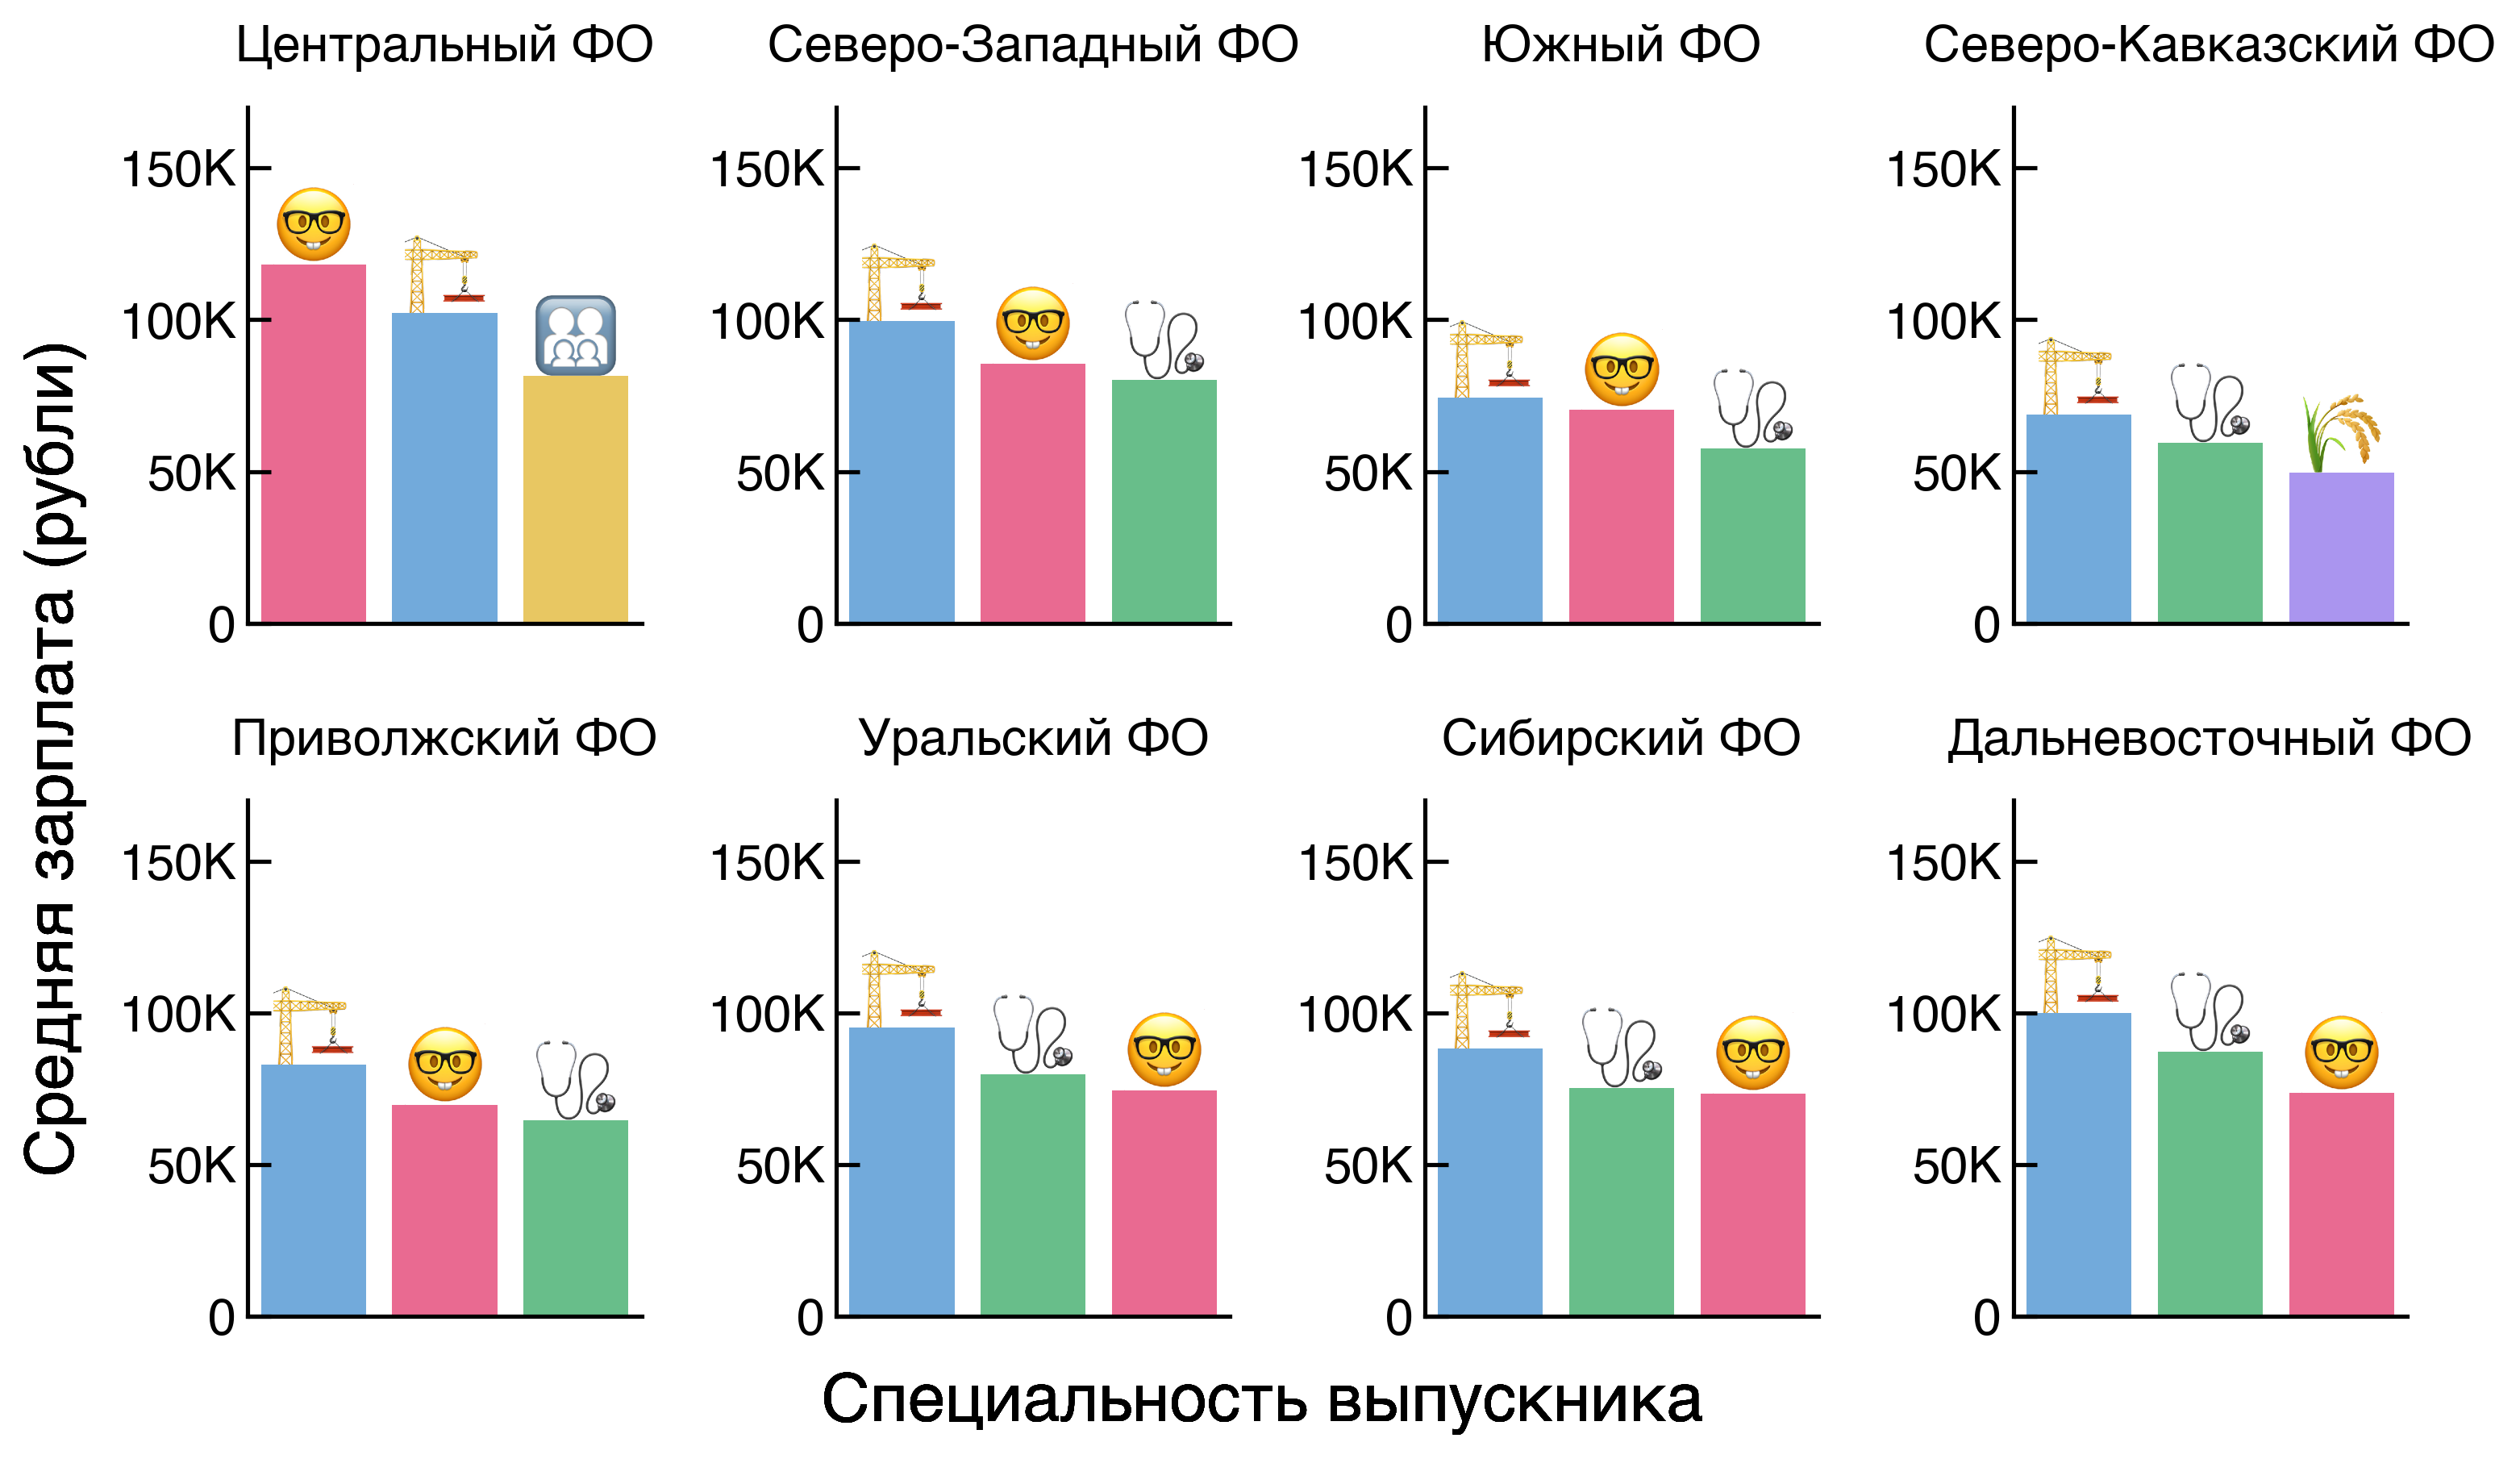

In [5]:
plot_top_salaries_by_fd(fed_dist_bachelor_df)

<span style="font-size: 20px;">cреди выпускников бакалавриата и специалитета</span>

- Только выпускники <img src="./data/img/engineer.png" width="20"/> <font color="#1E88E5">инженерных и технических</font> специальностей входят в топ-3 по среднему размеру зарплат во всех федеральных округах

- Только в Центральном ФО выпускники <img src="./data/img/nerd.png" width="20"/> <font color="#ff0d57">математических и естестеннонаучных</font> специальностей получают больше остальных

- Только в Центральном ФО выпускники <img src="./data/img/social.png" width="20"/> <font color="#FFC000">общественно-научных</font> специальностей входят в топ-3 по уровню зарплат

- Только в Северо-Кавказском ФО выпускники <img src="./data/img/rural.png" width="20"/> <font color="#7C52FF">сельскозозяйственных</font> специальностей входят в топ-3

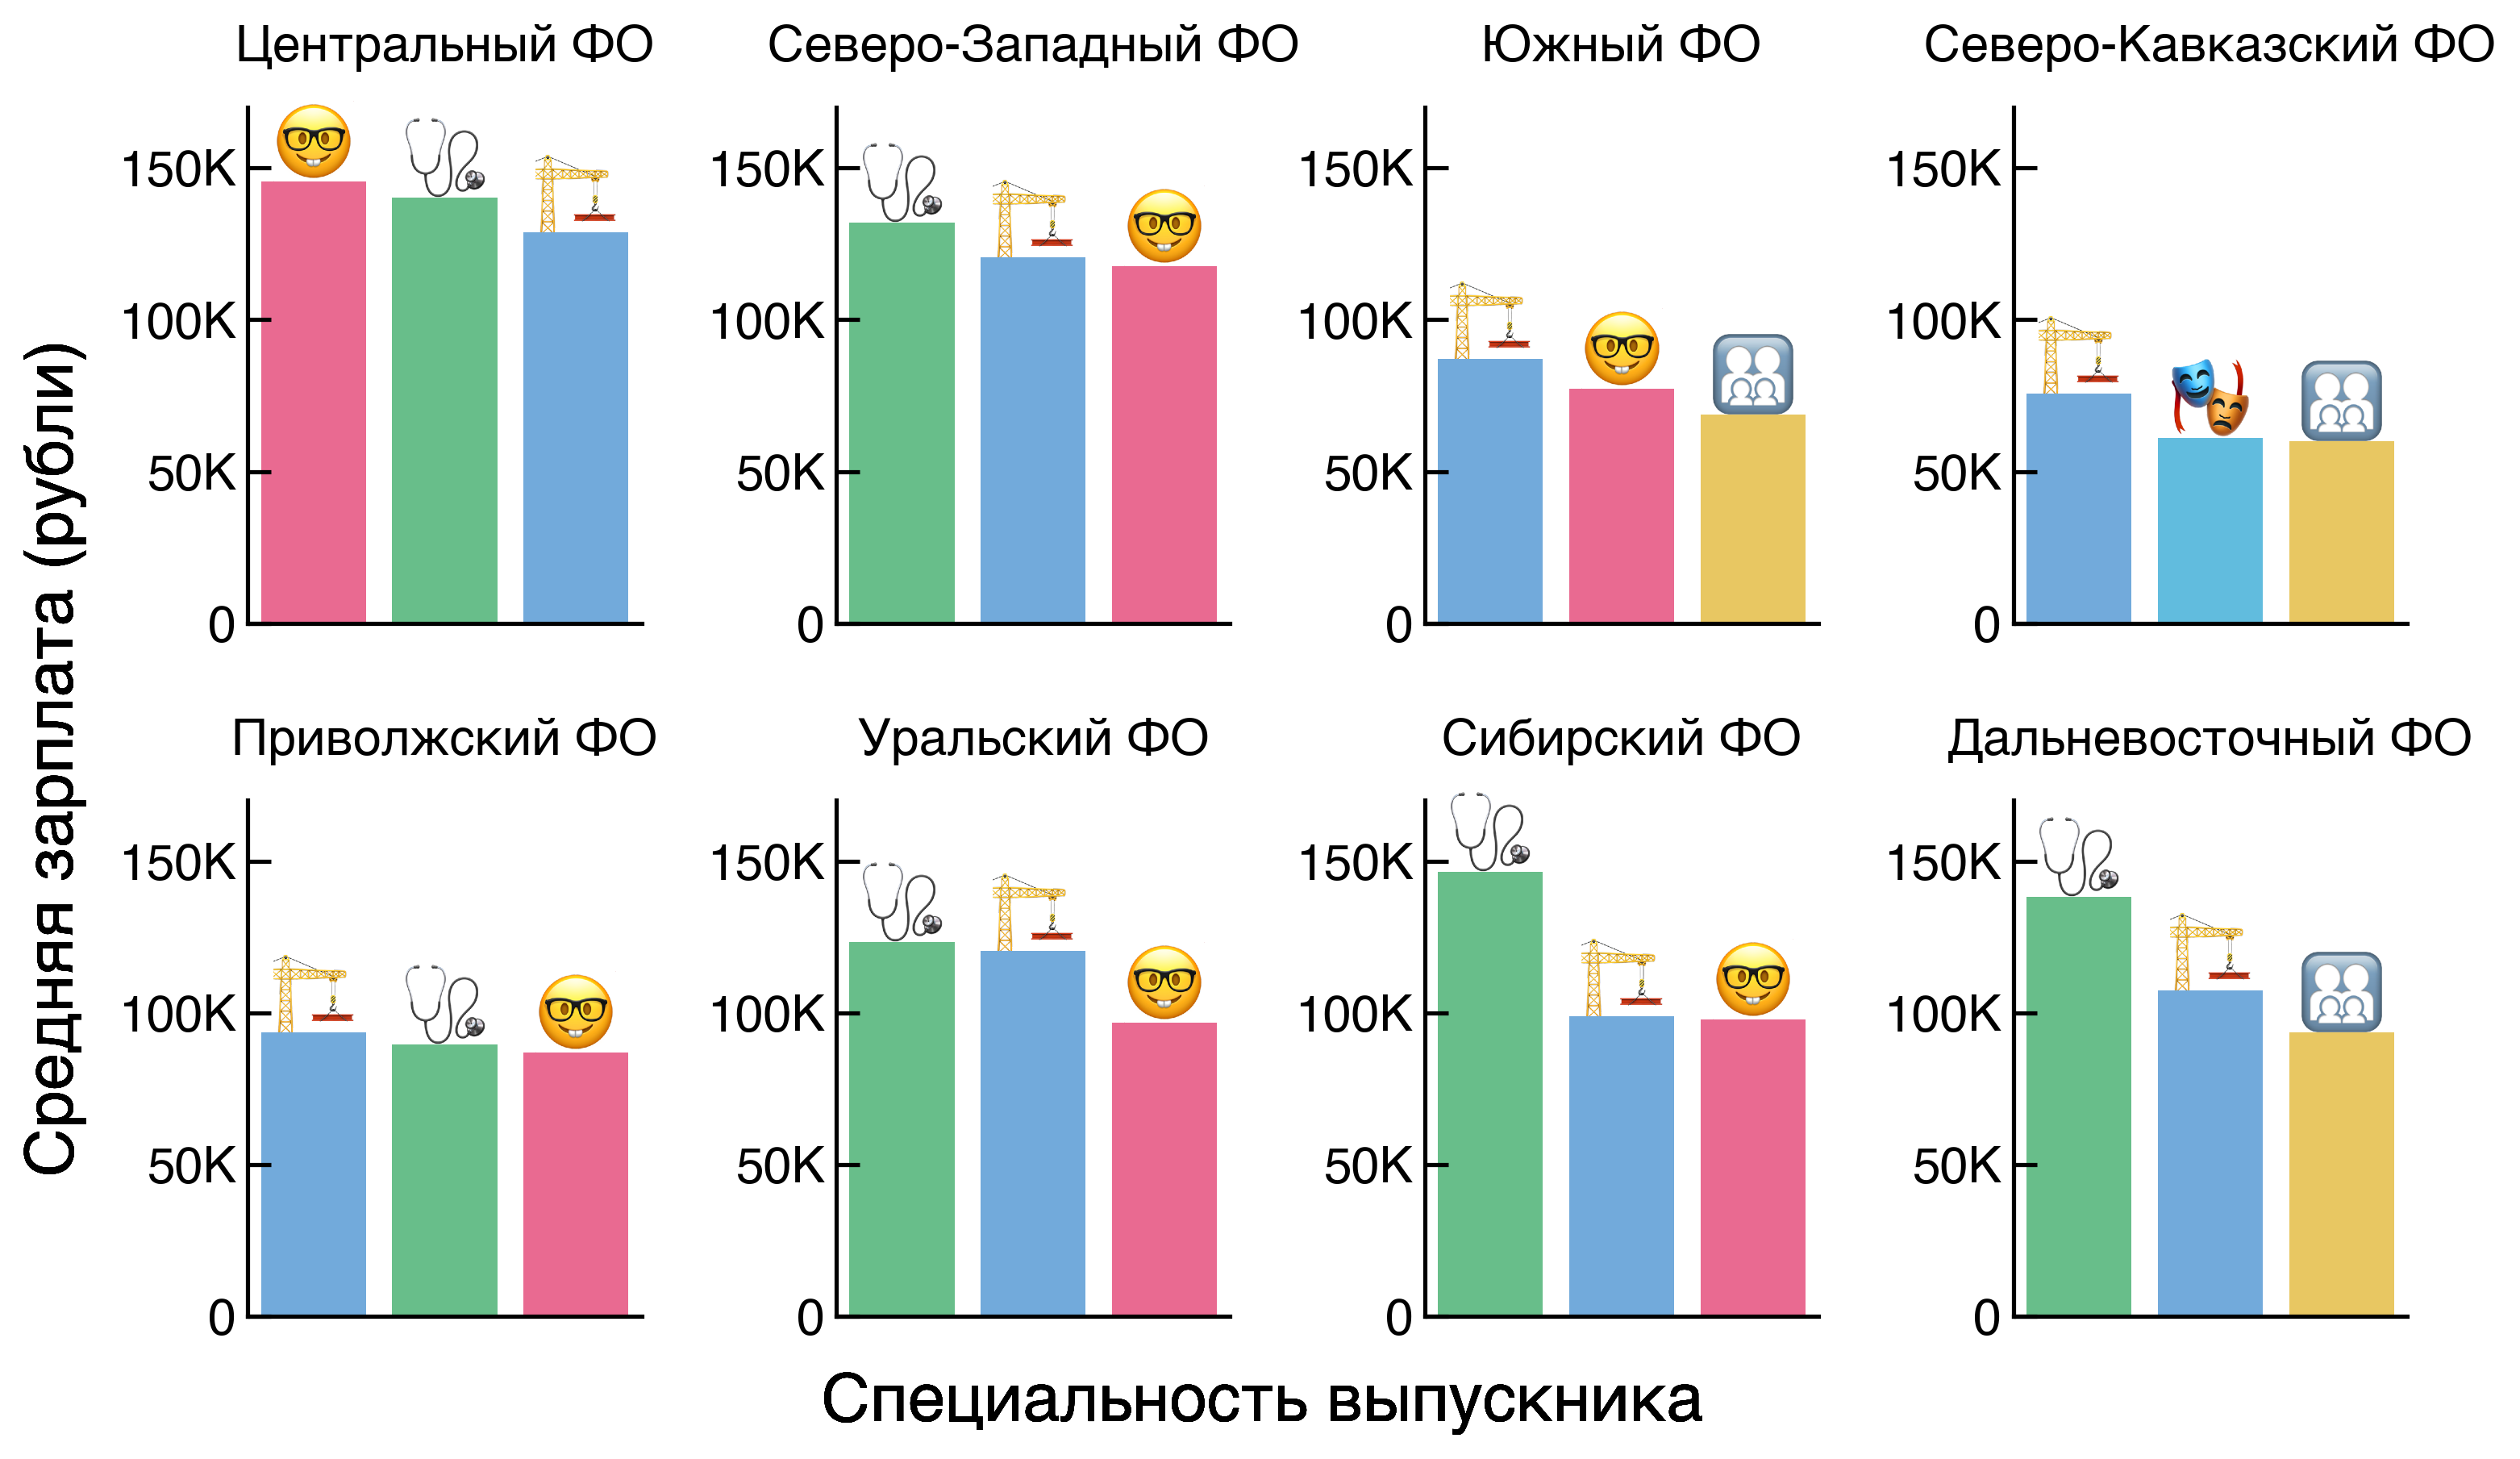

In [6]:
plot_top_salaries_by_fd(fed_dist_master_df)

<span style="font-size: 20px;">cреди выпускников магистратуры</span>

- Наиболее заметный рост зарплаты по отношению к выпускникам бакалавриата или специалитета наблюдается в Центральном и Северо-Западном федеральном округе

- Сопоставимый прирост в других ФО наблюдается только у выпускников <img src="./data/img/doctor.png" width="20"/> <font color="#13B755"> медицинских специальностей </font>, особенно он заметен в Сибирском и Дальневосточном ФО

- Магистры <img src="./data/img/doctor.png" width="20"/> <font color="#13B755"> медицинских специальностей </font> не входят в топ-3 по уровню зарплат в Южном и Северо-Кавказском округах

- Наименьший прирост зарплаты у магистров по сравнению с бакалаврами/специалистами наблюдается в Приволжском и Северо-Кавказском округах

***

<font color="gray">

- ~~Есть ли разница между зарплатами магистров и баколавров/специалистов?~~

- Нужно ли нанести долю занятых на карту?

- Отобразить прирост зарплат на графике образовательная категория - изменение

- Проявляются ли гендерные различия?